# Web Scraping and Analysis of Skytrax Data

---

In this project, we perform a comprehensive analysis of customer reviews for British Airways. The process begins by scraping reviews from a website, cleaning the data, and then performing sentiment analysis using TextBlob. We categorize the reviews into various aspects of the airline experience—such as service, comfort, food, timeliness, and price—to understand the sentiment associated with each category.

To gain deeper insights, we also apply topic modeling using Latent Dirichlet Allocation (LDA) to discover underlying themes in the reviews. Additionally, visualizations, including bar charts, pie charts, and word clouds, help in understanding the sentiment and topic distributions across different aspects of the customer experience. This analysis ultimately provides a clearer picture of customer feedback and highlights areas where the airline excels or could improve.

Importing several essential libraries for a web scraping and data analysis project. requests and BeautifulSoup are used to fetch and parse web pages, while pandas is used for data manipulation. Regular expressions (re) help with text pattern matching, and TextBlob is used for sentiment analysis. Visualization tools such as matplotlib and WordCloud are also imported. Additionally, CountVectorizer and LatentDirichletAllocation from sklearn are used for text feature extraction and topic modeling.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import pandas as pd
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

This script scrapes reviews of British Airways from a specified website. It loops through a defined number of pages (pages = 10) to collect reviews, each page containing up to 100 reviews. For each page, the script constructs a URL, sends an HTTP GET request using the requests library, and parses the HTML content using BeautifulSoup. It then extracts the review text from div elements with the class text_content and appends the text to a list of reviews. The progress is printed after each page is processed, including the cumulative count of reviews scraped.

In [2]:
# Define base URL for the British Airways reviews
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"

# Set the number of pages to scrape and the number of reviews per page
pages = 10
page_size = 100

# Initialize an empty list to store the reviews
reviews = []

# Loop through the specified number of pages to collect reviews
for i in range(1, pages + 1):

    # Print status message indicating current page being scraped
    print(f"Scraping page {i}")

    # Construct the URL for each page of reviews, including sorting by date (descending) and setting page size
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Send an HTTP GET request to the constructed URL
    response = requests.get(url)

    # Extract the HTML content from the response
    content = response.content

    # Parse the HTML content using BeautifulSoup for easy navigation
    parsed_content = BeautifulSoup(content, 'html.parser')

    # Extract review text from all div elements with the class 'text_content'
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    # Print the total number of reviews collected so far
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


This code creates a pandas DataFrame to store the scraped reviews. It initializes an empty DataFrame and adds a column named reviews containing the list of collected reviews. Finally, it displays the first few rows of the DataFrame using the head() function, allowing verification of the scraped data before further analysis.

In [3]:
# Create an empty DataFrame using pandas to store the scraped data
df = pd.DataFrame()

# Add the collected reviews as a column named 'reviews' in the DataFrame
df["reviews"] = reviews

# Display the first few rows of the DataFrame to verify the data
df.head()

,reviews
0,✅ Trip Verified | I’ve flown with many airline...
1,✅ Trip Verified | I recently flew from New Y...
2,Not Verified | BA business class in Europe h...
3,✅ Trip Verified | Our flight started in Seattl...
4,✅ Trip Verified | British Airways Flight fro...


The function clean_text is used to clean up the reviews by removing unnecessary elements such as the "Trip Verified" and "Not Verified" tags, emojis, punctuation, and extra spaces. After cleaning, the reviews are saved in a new column called cleaned_reviews. This allows for easy comparison between the original and cleaned versions of the reviews.

In [4]:
# Define a function to clean the text data
def clean_text(text):
    # Remove emojis, special characters, and "Trip Verified" tags
    text = re.sub(r'✅ Trip Verified \| ', '', text)
    text = re.sub(r'Not Verified \|', '', text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text.strip()

# Apply the cleaning function to the 'reviews' column
df['cleaned_reviews'] = df['reviews'].apply(clean_text)


# Display the first few rows of the cleaned DataFrame
df[['reviews', 'cleaned_reviews']].head()

,reviews,cleaned_reviews
0,✅ Trip Verified | I’ve flown with many airline...,Ive flown with many airlines but my recent exp...
1,✅ Trip Verified | I recently flew from New Y...,I recently flew from New York back to London w...
2,Not Verified | BA business class in Europe h...,BA business class in Europe has a seat the sam...
3,✅ Trip Verified | Our flight started in Seattl...,Our flight started in Seattle Wa heading to Li...
4,✅ Trip Verified | British Airways Flight fro...,British Airways Flight from Edinburgh got dela...


Sentiment analysis is applied to the cleaned reviews using TextBlob. The function analyze_sentiment calculates the polarity of each review, which helps determine whether the sentiment is positive, neutral, or negative. These sentiment scores are then saved in a new column called sentiment_score and displayed along with the cleaned reviews for further analysis.

In [5]:
# Define afunction to perform sentiment analysis using TextBlob
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to the 'cleaned_reviews' column
df['sentiment_score'] = df['cleaned_reviews'].apply(analyze_sentiment)

# Display the first few rows of the DataFrame with sentiment scores
df[['cleaned_reviews', 'sentiment_score']].head()

,cleaned_reviews,sentiment_score
0,Ive flown with many airlines but my recent exp...,0.019805
1,I recently flew from New York back to London w...,0.180978
2,BA business class in Europe has a seat the sam...,0.006169
3,Our flight started in Seattle Wa heading to Li...,0.028076
4,British Airways Flight from Edinburgh got dela...,-0.085714


Reviews are categorized into different aspects of the airline experience, such as service, comfort, food, timeliness, and price, using predefined keywords for each category. The function categorize_review looks for these keywords in each review to assign it to a relevant category. If none of the keywords match, the review is classified as 'other'. This allows for a better understanding of which aspects of the airline experience are most frequently mentioned and their associated sentiment.

In [6]:
# Define keywords to categorize reviews into different aspects of the airline experience
categories = {
    'service': ['service', 'staff', 'crew', 'attendant'],
    'comfort': ['seat', 'comfort', 'legroom'],
    'food': ['food', 'meal', 'dinner', 'breakfast'],
    'timeliness': ['delay', 'late', 'on time', 'punctual'],
    'price': ['price', 'cost', 'expensive', 'cheap']
}

# Define a function to categorize each review based on keywords
def categorize_review(text, categories):
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in text.lower():
                return category
    return 'other'

# Apply categorization to the cleaned reviews
df['category'] = df['cleaned_reviews'].apply(lambda x: categorize_review(x, categories))

# Display the first few rows of the DataFrame with categories
df[['cleaned_reviews', 'category', 'sentiment_score']].head()

,cleaned_reviews,category,sentiment_score
0,Ive flown with many airlines but my recent exp...,service,0.019805
1,I recently flew from New York back to London w...,service,0.180978
2,BA business class in Europe has a seat the sam...,service,0.006169
3,Our flight started in Seattle Wa heading to Li...,service,0.028076
4,British Airways Flight from Edinburgh got dela...,timeliness,-0.085714


The cleaned reviews are analyzed to identify underlying topics using Latent Dirichlet Allocation (LDA). First, the reviews are transformed into a document-term matrix using CountVectorizer, considering the most frequent 1000 words while ignoring common English stop words. The LDA model is then trained to identify a predefined number of topics (num_topics = 3). Finally, the display_topics function retrieves the top words for each topic, giving insight into the key themes present in the reviews.

In [7]:
# Define a function to display the top words in each topic
def display_topics(model, feature_names, num_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-num_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics[f"Topic {topic_idx + 1}"] = ', '.join(top_features)
    return topics

# Convert the cleaned reviews into a document-term matrix
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
dtm = vectorizer.fit_transform(df['cleaned_reviews'])

# Fit an LDA model with a predefined number of topics
num_topics = 3
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Display the top words in each topic
num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda, feature_names, num_top_words)

# Display the topics to the user
topics

{'Topic 1': 'ba, class, business, seat, seats, flight, service, economy, airline, british',
 'Topic 2': 'flight, crew, good, ba, food, cabin, service, time, boarding, club',
 'Topic 3': 'flight, ba, british, airways, customer, london, told, service, hours, airport'}

The average sentiment score for each category of reviews is calculated to understand how customers feel about different aspects of the airline experience, such as service, comfort, food, etc. The results are visualized as a bar chart, with each category on the x-axis and the average sentiment score on the y-axis. A red dashed line is added at y=0 to highlight the boundary between positive and negative sentiment. This helps in identifying which areas of the airline experience have generally positive or negative customer feedback.

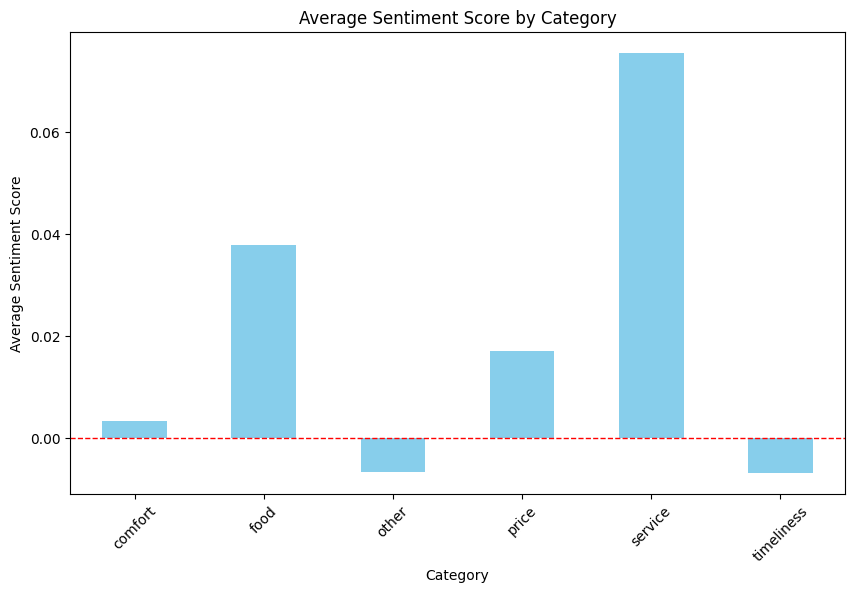

In [8]:
# Calculate the average sentiment score for each category
average_sentiment_by_category = df.groupby('category')['sentiment_score'].mean()

# Plot the average sentiment scores by category as a bar chart
plt.figure(figsize=(10, 6))
average_sentiment_by_category.plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score by Category')
plt.xticks(rotation=45)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Adding a line at y=0 to distinguish positive/negative
plt.show()

A pie chart is created to show the distribution of review categories, which helps visualize the proportion of reviews that focus on different aspects of the airline experience, such as service, comfort, food, timeliness, and price. The chart displays each category as a slice with a corresponding percentage, making it easy to see which areas are most commonly mentioned in customer reviews. The pie chart is drawn to be a perfect circle for better readability.

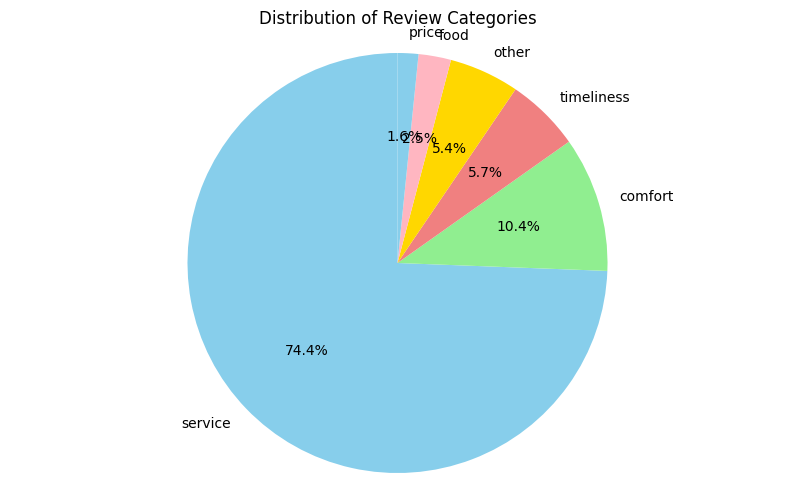

In [10]:
# Create a pie chart for the distribution of review categories
plt.figure(figsize=(10, 6))
category_counts = df['category'].value_counts()
category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink'])
plt.ylabel('')
plt.title('Distribution of Review Categories')
plt.axis('equal')  # Ensures that pie is drawn as a circle
plt.show()

Word clouds are generated for each topic identified by the LDA model to provide a visual representation of the most important words for each topic. The top 50 words for each topic are extracted and combined into a word cloud, highlighting the words that are most strongly associated with that topic. Each word cloud is displayed in a separate subplot, with the overall figure showing all the topics side by side. This visualization makes it easier to understand the dominant themes within each topic.

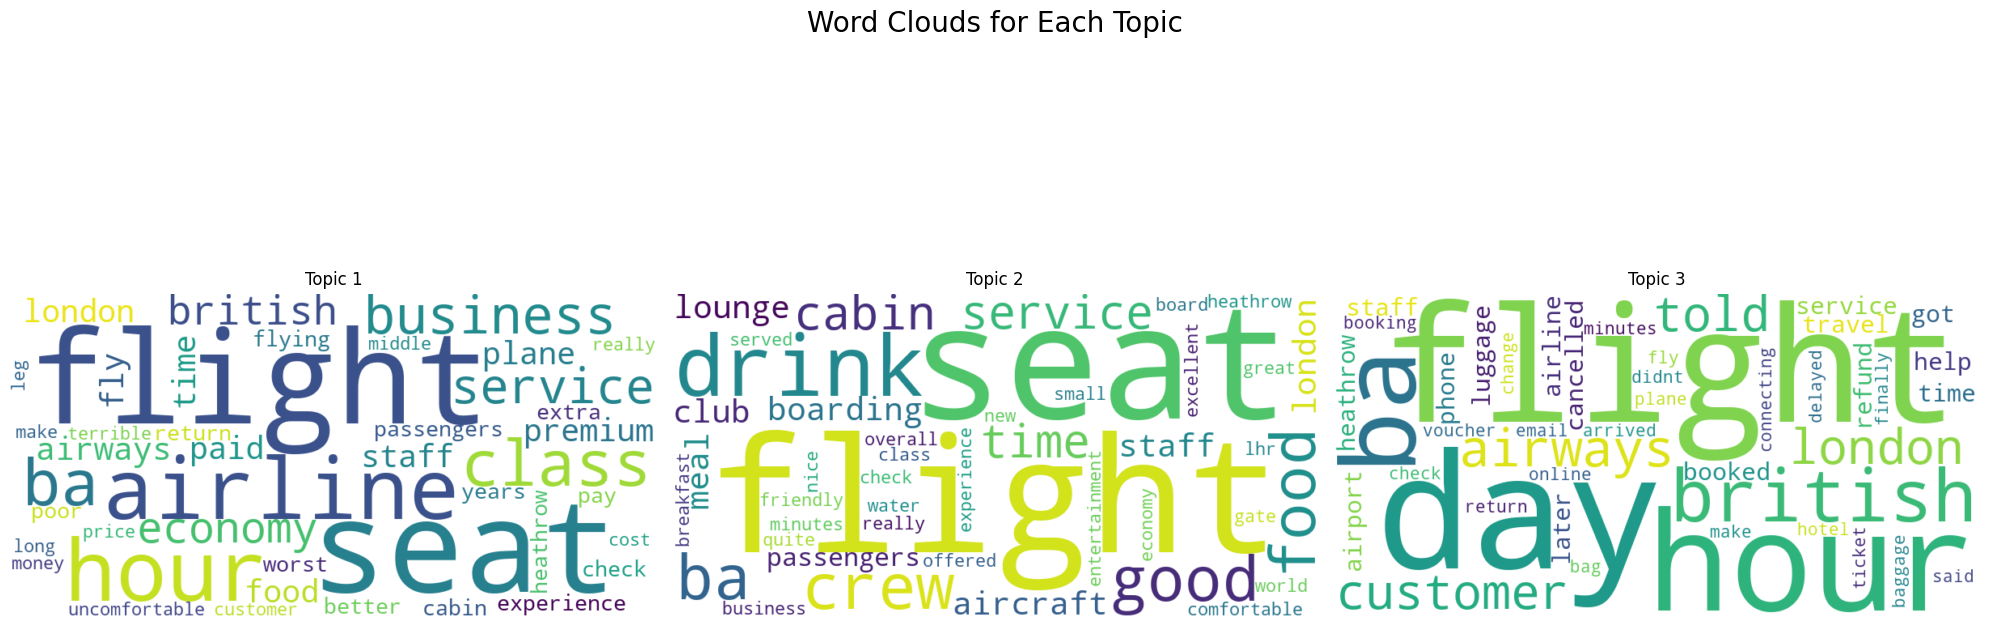

In [12]:
# Generate word clouds for each topic identified by the LDA model
fig, axes = plt.subplots(1, num_topics, figsize=(20, 8))
topic_words = lda.components_

for topic_idx, topic in enumerate(topic_words):
    top_features_ind = topic.argsort()[:-50 - 1:-1]  # Using the top 50 words for each topic
    top_features = [feature_names[i] for i in top_features_ind]
    topic_wordcloud_text = ' '.join(top_features)

    # Generate the word cloud for each topic
    topic_wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(topic_wordcloud_text)

    # Display the word cloud
    axes[topic_idx].imshow(topic_wordcloud, interpolation='bilinear')
    axes[topic_idx].axis('off')
    axes[topic_idx].set_title(f'Topic {topic_idx + 1}')

fig.suptitle('Word Clouds for Each Topic', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

## Summary of Findings
- The analysis highlights service as the primary focus of customer reviews, with a generally positive sentiment. However, there are areas like price and timeliness that need attention to improve the overall customer - experience.
- The word clouds reveal common themes and areas of concern, such as business class amenities, general flight experience, and issues with refunds or service quality.
- The distribution and sentiment analysis provide a deeper understanding of which aspects of the airline experience are most important to customers and how they perceive them, allowing the airline to identify strengths and areas needing improvement.